<a href="https://colab.research.google.com/github/jpwoods1878/titanic-survival-prediction/blob/main/load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/jpwoods1878/titanic-survival-prediction.git

Cloning into 'titanic-survival-prediction'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 52 (delta 15), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 96.88 KiB | 1.61 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

project_root = "/content/titanic-survival-prediction"
os.chdir(project_root)
sys.path.append(os.path.join(project_root, "src"))
print("Project root set to:", os.getcwd())

Project root set to: /content/titanic-survival-prediction


# Loading in the data

Load our training data in via pandas, the training set consists of 891 rows. We
have 12 columns. PassengerId which is a unique identifier for each passenger. Survived which will be our target, Pclass is the class the passenger travelled in. Passenger name, age and gender. SibSp which is the count of siblings/spouses on board, Parch which is the number of parents/children on board. Ticket cost, cabin number and ticket number. And finally port of embarkation. Using these features we aim to predict whether a passenger survived or not and we will evaluate our success on the test set.

In [5]:
train_df = pd.read_csv('data/train.csv')
train_df.shape

(891, 12)

In [6]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA

Once we have read the data into our workspace, the next steps are to assess our target and features to get an idea of how we might model this problem.

From the dataframe output above Name, Ticket and Cabin are features that at first glance look useless in their current form. We will need to do some preprocessing to get any use out of these. With some intuition some of the other features seem like good indicators of whether someone would survive the disaster, for instance perhaps younger age passengers are more likely to survive, or passengers travelling in a higher class. We will summarise these fields below to find out if this really was case.

We can also see that we have some null values in some of our features that we will need to impute, we will come back to these later.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


The target variable shows a 62% vs. 38% distribution, with the majority of passengers not surviving the disaster. Other than the fact this shows what a tragic event this was, for us it epresents a moderate class imbalance, but not an extreme one. Most standard models can handle this level of imbalance without special techniques such as SMOTE, class-weighting, or resampling.

However, since accuracy can be misleading in imbalanced datasets, evaluation metrics like precision, recall, F1-score, ROC-AUC, and confusion matrices will give a more reliable picture of performance.

In [8]:
train_df['Survived'].value_counts(normalize=True)


,proportion
Survived,
0,0.616162
1,0.383838


<Axes: xlabel='Survived', ylabel='count'>

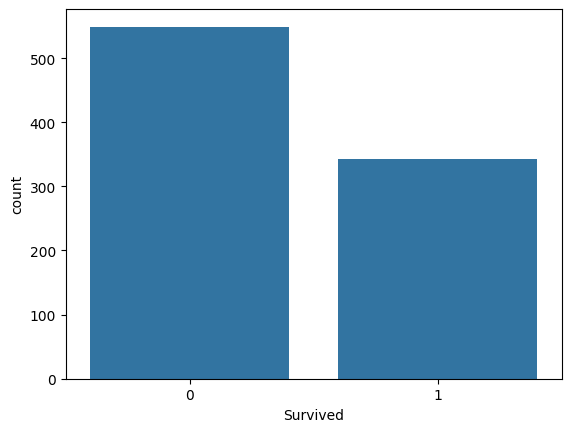

In [9]:
import seaborn as sns
sns.countplot(x='Survived', data=train_df)


We will start by examining the numerical features and guaging how they interact with our target. At this point we will split the data into out train and validate sets to avoid any data leakage even at this early stage.

Looking at the distribution of the numeric features we see ...

In [25]:
from sklearn.model_selection import train_test_split

# X = features, y = target
X_train_full = train_df.drop(["Survived", "PassengerId"], axis=1)
y_train_full = train_df["Survived"]

# Step 1: train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,       # 20% for validation
    random_state=42,
    stratify=y_train_full  # keeps survival ratio the same
)


array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

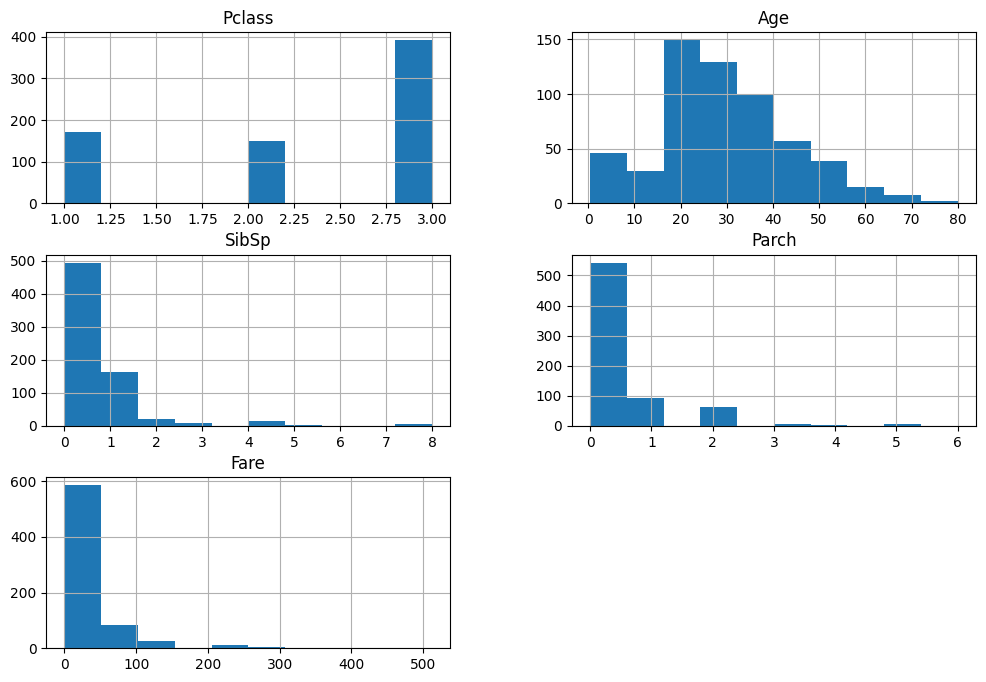

In [26]:
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(exclude=['int64', 'float64']).columns

X_train[num_cols].hist(figsize=(12,8))


Apart from 'Sex' and 'Embarked', the categorical columns need some work in order to extract and value from, or even assess their relationship with the target. We will try and engineer some features from these columns before assessing the numeric and categorical features.

In [27]:
for col in cat_cols:
    print(f"\nColumn: {col}")
    print(X_train[col].head())



Column: Name
692                                   Lam, Mr. Ali
481               Frost, Mr. Anthony Wood "Archie"
527                             Farthing, Mr. John
855                     Aks, Mrs. Sam (Leah Rosen)
801    Collyer, Mrs. Harvey (Charlotte Annie Tate)
Name: Name, dtype: object

Column: Sex
692      male
481      male
527      male
855    female
801    female
Name: Sex, dtype: object

Column: Ticket
692          1601
481        239854
527      PC 17483
855        392091
801    C.A. 31921
Name: Ticket, dtype: object

Column: Cabin
692    NaN
481    NaN
527    C95
855    NaN
801    NaN
Name: Cabin, dtype: object

Column: Embarked
692    S
481    S
527    S
855    S
801    S
Name: Embarked, dtype: object


We have added a function to preprocessing that cleans the 'Title' column and will be used on train, validate and test to clean the data for modelling. It keeps the well populated titles, maps "Ms" and "Mlle" to "MISS" and all other titles will be added to a "RARE" category.

In [31]:
from preprocessing import map_titles

train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
print("Unclean titles and value counts :", train_df['Title'].value_counts())

train_df = map_titles(
    df=train_df,
    column="Name",
    new_column="Title",
)

Unclean titles and value counts : Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-39622234.py:3: SyntaxWarning: invalid escape sequence '\.'
  train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


Clearly value in the title, 'MRS' and 'MR' have a much higher survival rate than the male equivalent titles.

In [33]:
survival_stats = train_df.groupby('Title')['Survived'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(survival_stats)


            mean  count
Title                  
MRS     0.792000    125
MISS    0.702703    185
MASTER  0.575000     40
RARE    0.375000     24
MR      0.156673    517
